<a href="https://colab.research.google.com/github/ingridheuer/GCNN_for_GDAs/blob/main/exploration/notebooks/RSAGE_nofeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalo e importo librerias

In [1]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
#Librería base de redes neuronales de torch
#Acá están las clases "base" de las que heredan todos los modelos
import torch.nn as nn

#Operaciones entre sparse matrix
from torch_sparse import matmul, SparseTensor

#Librerías específicas de GNNs: 
#PYG es la libraría general de GNNs,
#DeepSNAP tiene utilidades para el manejo de datos y grafos heterogeneos, hacer splits, negative sampling, etc.
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import HeteroConv
from deepsnap.dataset import GraphDataset
import deepsnap.hetero_gnn
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_geometric.utils import to_undirected
#from torch_geometric.data import HeteroData

#Para manejar los minibatches
from torch.utils.data import DataLoader
from deepsnap.batch import Batch

from timeit import default_timer as timer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import copy

# Modelo

In [3]:
def edgeindex_to_sparsematrix(het_graph: HeteroGraph) -> dict : 
    sparse_edge_dict = {}
    for key in het_graph.edge_index:
        temp_edge_index = het_graph.edge_index[key]
        from_type = key[0]
        to_type = key[2]
        adj = SparseTensor(row=temp_edge_index[0], col=temp_edge_index[1], sparse_sizes=(het_graph.num_nodes(from_type), het_graph.num_nodes(to_type)))
        sparse_edge_dict[key] = adj.t()
    return sparse_edge_dict

# %%
debugging = False

def my_debug(arg):
    if debugging:
        print(arg)
#%%
#OLD DICT STYLE
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super().__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels
        self.lin_dst = torch.nn.Linear(in_channels_dst, out_channels)
        self.lin_src = torch.nn.Linear(in_channels_src, out_channels)
        self.lin_update = torch.nn.Linear(2*out_channels, out_channels)

    def forward(
            self,
            node_feature_src,
            node_feature_dst,
            edge_index,
            size=None):

        out = self.propagate(
            edge_index, size, node_feature_src=node_feature_src, node_feature_dst=node_feature_dst)
        return out

    def message_and_aggregate(self, edge_index, node_feature_src):
        out = matmul(edge_index, node_feature_src, reduce=self.aggr)
        #my_debug(f'message_and_agregate out: {out}')

        return out

    def update(self, aggr_out, node_feature_dst):

        dst_msg = self.lin_dst(node_feature_dst)
        src_msg = self.lin_src(aggr_out)
        full_msg = torch.concat((dst_msg, src_msg), dim=1)
        out = self.lin_update(full_msg)
        #my_debug(f'update out: {out}')
        return out


class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super().__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

    def reset_parameters(self):
        super().reset_parameters()

    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        #my_debug(f'Wrapper self convs: {self.convs}')
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            # my_debug(message_key)
            # my_debug(node_features.shape)
            #my_debug(f"Input x shape: {node_features.shape}")
            #my_debug(f'Wrapper self conv step: {self.convs[message_key]}')
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            #my_debug(f'Wrapper message_type_emb step: {self.convs[message_key](node_feature_src,node_feature_dst,edge_index)}')
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
            #my_debug(f'{message_key} emb done: {message_type_emb}')
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        #my_debug(f'node emb: {node_emb}')
        mapping = {}
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        #my_debug(f'node_emb from wrapper conv forward:{node_emb}')
        return node_emb

    def aggregate(self, xs):
        return torch.mean(torch.stack(xs), dim=0)


def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    convs = {}

    msg_types = hetero_graph.message_types
    for key in msg_types:
        if first_layer:
            dst_feature_dim = hetero_graph.num_node_features(key[2])
            src_feature_dim = hetero_graph.num_node_features(key[0])
            convs[key] = conv(src_feature_dim, dst_feature_dim, hidden_size)
        else:
            convs[key] = conv(hidden_size, hidden_size, hidden_size)

    return convs


class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph_dict, args, aggr="mean"):
        super().__init__()

        hetero_graph = hetero_graph_dict["graph"]
        self.aggr = aggr
        self.hidden_size = args['hidden_size']
        self.bns1 = torch.nn.ModuleDict()
        self.bns2 = torch.nn.ModuleDict()
        self.relus1 = torch.nn.ModuleDict()
        self.relus2 = torch.nn.ModuleDict()
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        #self.post_mps = nn.ModuleDict()

        convs1 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True)
        #my_debug(f'convs1: {convs1}')
        convs2 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=False)
        self.convs1 = HeteroGNNWrapperConv(convs1, args, aggr=self.aggr)
        #my_debug(f'self.convs1: {self.convs1}')
        self.convs2 = HeteroGNNWrapperConv(convs2, args, aggr=self.aggr)
        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size)
            self.bns2[node_type] = torch.nn.BatchNorm1d(self.hidden_size)
            self.relus1[node_type] = torch.nn.LeakyReLU()
            self.relus2[node_type] = torch.nn.LeakyReLU()

    def forward(self, graph_dict):
        #x, adj, edge_label_index = graph_dict["graph"].node_feature, graph_dict["adj"], graph_dict["graph"].edge_label_index
        x,edge_label_index = graph_dict["graph"].node_feature, graph_dict["graph"].edge_label_index
        adj = edgeindex_to_sparsematrix(graph_dict["graph"])
        x = self.convs1(x, edge_indices=adj)
        x = deepsnap.hetero_gnn.forward_op(x, self.bns1)
        x = deepsnap.hetero_gnn.forward_op(x, self.relus1)
        x = self.convs2(x, edge_indices=adj)
        x = deepsnap.hetero_gnn.forward_op(x, self.bns2)
        #my_debug(f"Output x shape: {x.shape}")
        x = deepsnap.hetero_gnn.forward_op(x, self.relus2)
        #x = forward_op(x, self.post_mps)

        pred = {}
        for message_type in edge_label_index:
            my_debug(f"{len(edge_label_index[message_type][0])}")
            src_type = message_type[0]
            trg_type = message_type[2]
            nodes_first = torch.index_select(x[src_type], 0, edge_label_index[message_type][0,:].long())
            nodes_second = torch.index_select(x[trg_type], 0, edge_label_index[message_type][1,:].long())
            my_debug(f"Multiplying shapes {nodes_first.shape}, {nodes_second.shape}")
            pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
            my_debug(f"Pred shape {pred[message_type].shape}")
        return pred

    def loss(self, pred, y):
        loss = 0
        for key in pred:
            p = torch.sigmoid(pred[key])
            loss += self.loss_fn(p, y[key].type(pred[key].dtype))
        return loss

# Preprocesamiento del dataset

In [4]:
node_data = pd.read_csv("/content/graph_node_table.csv", index_col=0)
edge_data = pd.read_csv("/content/graph_edge_table.csv",index_col=0).rename(columns={"relation":"edge_type"})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
D = nx.from_pandas_edgelist(edge_data,source="a_idx",target="b_idx", edge_attr="edge_type", create_using=nx.DiGraph)
nx.set_node_attributes(D,pd.Series(node_data.node_type, index=node_data.node_idx).to_dict(),"node_type")
nx.set_node_attributes(D,pd.Series(node_data.node_name, index=node_data.node_idx).to_dict(),"node_name")

#G = nx.to_undirected(D)
G = D

node_id = 5
print(f"Node {node_id} has properties:", G.nodes(data=True)[node_id])
# %%
edges = list(G.edges())
edge_idx = 123456
n1 = edges[edge_idx][0]
n2 = edges[edge_idx][1]
edge = list(G.edges(data=True))[edge_idx]
print(f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
print(f"Node {n1} has properties:", G.nodes(data=True)[n1])
print(f"Node {n2} has properties:", G.nodes(data=True)[n2])
#%%
G_deepsnap = HeteroGraph(G)
G_deepsnap.edge_types
G_deepsnap.message_types
G_deepsnap.node_types
G_deepsnap.num_nodes()
G_deepsnap.num_edges()
list(G.edges(data=True))[0]

Node 5 has properties: {'node_type': 'gene/protein', 'node_name': 'SERPINA3'}
Edge (4873, 15076) has properties: {'edge_type': 'GDA'}
Node 4873 has properties: {'node_type': 'gene/protein', 'node_name': 'IQSEC1'}
Node 15076 has properties: {'node_type': 'disease', 'node_name': 'Short stature'}


(1839, 14989, {'edge_type': 'GDA'})

In [6]:
node_feature = torch.ones(5)
nx.set_node_attributes(G, node_feature, 'node_feature')
hete = HeteroGraph(G)
task = 'link_pred'
dataset = GraphDataset([hete], task=task, edge_train_mode="all")
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

# Funciones de entrenamiento y evaluación

In [7]:
def train(model, optimizer, graph_dict, printb):
    model.train()
    optimizer.zero_grad()
    preds = model(graph_dict)
    loss = model.loss(preds, graph_dict["graph"].edge_label)
    loss.backward()
    optimizer.step()
    if printb:
        print(loss.item())
    return loss.item()


# Test function
def test(model, graph_dict, args):
    model.eval()
    accs = {}
    for mode, dataset in graph_dict.items():
        acc = 0
        num = 0
        pred = model(dataset)
        for key in pred:
            p = torch.sigmoid(pred[key]).cpu().detach().numpy()
            pred_label = np.zeros_like(p, dtype=np.int64)
            pred_label[np.where(p > 0.5)[0]] = 1
            pred_label[np.where(p <= 0.5)[0]] = 0
            acc += np.sum(pred_label == dataset["graph"].edge_label[key].cpu().numpy())
            num += len(pred_label)
        accs[mode] = acc / num
    return accs


# Entrenamiento

In [8]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 32,
    'weight_decay': 1e-5,
    'lr': 0.003,
}

datasets = {"train":dataset_train, "val":dataset_val, "test":dataset_test}
sparse_dict = {title:{"graph":dataset[0].to(args["device"]), "adj":[]} for title,dataset in datasets.items()}
fullgraph_sparse_dict = {"graph":hete, "adj":[]}

model = HeteroGNN(fullgraph_sparse_dict, args, aggr="mean").to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

In [9]:
model

HeteroGNN(
  (bns1): ModuleDict(
    (gene/protein): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (disease): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (protein_complex): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bns2): ModuleDict(
    (gene/protein): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (disease): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (protein_complex): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relus1): ModuleDict(
    (gene/protein): LeakyReLU(negative_slope=0.01)
    (disease): LeakyReLU(negative_slope=0.01)
    (protein_complex): LeakyReLU(negative_slope=0.01)
  )
  (relus2): ModuleDict(
    (gene/protein): LeakyReLU(negative_slope=0.01)
    (disease): LeakyReLU(negative_slope=0.01)
    (protein_complex): LeakyReLU(negative

3.142920970916748
2.955369710922241
2.8683598041534424
2.8561649322509766
2.85170316696167
2.849128007888794
2.8462040424346924
2.8436973094940186
2.8411848545074463
2.8389668464660645
2.836660861968994
2.8342134952545166
2.8314638137817383
2.82920503616333
2.8265910148620605
2.8238422870635986
2.821122407913208
2.818341016769409
2.8156137466430664
2.8126869201660156
2.809678792953491
2.8067221641540527
2.8036134243011475
2.800494909286499
2.797459602355957
2.7943553924560547
2.791100025177002
2.7878284454345703
2.7838354110717773
2.7798280715942383
2.7765989303588867
2.7732510566711426
2.770289659500122
2.766963243484497
2.7636094093322754
2.760321855545044
2.7570395469665527
2.7540647983551025
2.750687837600708
2.7474594116210938
2.7442448139190674
2.7411715984344482
2.738152027130127
2.7352757453918457
2.7321951389312744
2.729226589202881
2.726356029510498
2.7234904766082764
2.720677614212036
2.717956304550171
2.7154531478881836
2.712733745574951
2.7102246284484863
2.707764387130737

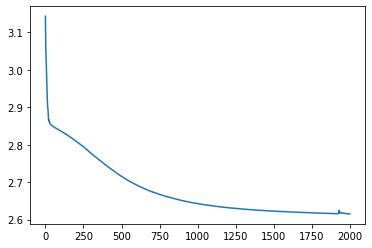

In [10]:
loss_plot = []
epochs = 2000
for epoch in range(epochs):
    if epoch%10 == 0:
       loss = train(model,optimizer,sparse_dict["train"],printb=True)
    else:
        loss = train(model,optimizer,sparse_dict["train"],printb=False)
    loss_plot.append(loss)

plt.plot(np.arange(len(loss_plot)),loss_plot)

In [11]:
p = model(sparse_dict["val"])
prediction = {edgetype:torch.round(torch.sigmoid(pred)) for edgetype,pred in p.items()}
ground_truth = dataset_val[0].edge_label

test(model,sparse_dict,args)

{'test': 0.6604004393848611,
 'train': 0.7115044330640102,
 'val': 0.6716266992897}